In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

[&lt;matplotlib.lines.Line2D at 0x1249bc88&gt;]

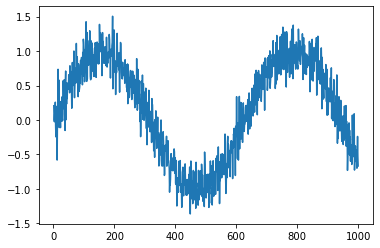

In [3]:
T = 1000 # Total Points
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
plt.plot(time, x)

In [10]:
## Creating features, labels 

tau = 4 # Seq length
features = tf.Variable(tf.zeros((T - tau, tau))) # feature size : 996, 4 
for i in range(tau):
    # print(i)
    features[:, i].assign(x[i : T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

In [12]:
batch_size, n_train = 16, 600
train_iter = tf.data.Dataset.from_tensor_slices((features[:n_train], labels[:n_train])).batch(batch_size)

In [16]:
def get_net():
    net = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(1)])
    return net

In [17]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

In [26]:
epochs = 10 
net = get_net()
for epoch in range(epochs):
    for X, y in train_iter:
        with tf.GradientTape() as tape:
            out = net(X)
            mse = loss(out, y)/2
            params = net.trainable_variables
            grads = tape.gradient(mse, params)
        optimizer.apply_gradients(zip(grads, params))
    print(f'epoch {epoch+1}, loss {loss(net(features), labels)}')

epoch 1, loss 0.13075608015060425
epoch 2, loss 0.08946632593870163
epoch 3, loss 0.08776815980672836
epoch 4, loss 0.07399410009384155
epoch 5, loss 0.07176946848630905
epoch 6, loss 0.06435549259185791
epoch 7, loss 0.06373082846403122
epoch 8, loss 0.05995503440499306
epoch 9, loss 0.06014123186469078
epoch 10, loss 0.05800184607505798


&lt;matplotlib.legend.Legend at 0x15a4d6c8&gt;

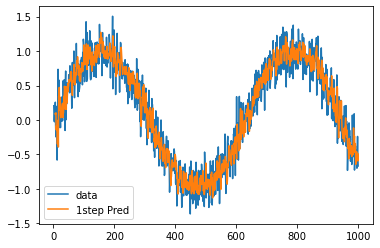

In [28]:
one_step_prediction = net(features)
plt.plot(time, x, label = 'data')
plt.plot(time[tau:], one_step_prediction.numpy(), label = '1step Pred')
plt.legend()

### Observations

* One Step looks good, but we cannot hope to recieve such inputs till one-step predictions

* We need multi step predictions!

## Multi-Step Prediction

[&lt;matplotlib.lines.Line2D at 0x14582e08&gt;]

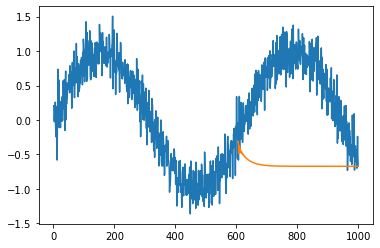

In [36]:
# Training Input is from 0:604
# Prediction 600:603 -> 604, 601:604 -> 605 ...
## You will see the value will decay get to a constant
### Mainly bcos the error gets added on as we move further into future prediction

multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau]) # till 0 : 604
for i in range(n_train + tau, T): # 604-1000
    multistep_preds[i].assign(tf.reshape(net(
        tf.reshape(multistep_preds[i - tau: i], (1, -1))), ()))


plt.plot(time, x)
plt.plot(time[n_train + tau:], multistep_preds[n_train + tau:])

## Summary

* autoregressive models: regression of time-steps. Good to approximate $x_t$ as function its last $\tau$ steps. 

* Latent-Variable autoregressive : They take into account of summary of past observations $h_t$ (hidden state) and keep updating that as well. 


Sequence models require specialized statistical tools for estimation. Two popular choices are autoregressive models and latent-variable autoregressive models.

For causal models (e.g., time going forward), estimating the forward direction is typically a lot easier than the reverse direction.

For an observed sequence up to time step  t , its predicted output at time step  t+k  is the :math:`k`-step-ahead prediction. As we predict further in time by increasing  k , the errors accumulate and the quality of the prediction degrades, often dramatically.
